In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.fft import fftn, ifftn, fftfreq,fft
#from spectral_derivative import  calc_deriv_fftn_with_ext#,calc_deriv_in_frequency_space
import os
import pynumdiff

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

2023-10-20 09:40:07,004 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-10-20 09:40:07,023 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-10-20 09:40:07,033 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



In [26]:
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,normalise
def compute_distance_svs(u,dx,fd_orders=range(2,8),norm=False):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        if norm:
            features = normalise(features)
        svs = svd(features, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

# Exponential function: $u(t,x)=exp(x+at)$

In [27]:
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1
exp(-0.741146843060084*t + x)


Noise level: 0
No normalisation: matrix rank = 1, svd = [1.82673727e+03 2.41130296e-09]
Normalisation: matrix rank = 1, svd = [1.00000000e+00 1.32000549e-12]
Noise level: 1e-10
No normalisation: matrix rank = 2, svd = [1.82673727e+03 1.12187928e-05]
Normalisation: matrix rank = 2, svd = [1.0000000e+00 6.1414375e-09]
Noise level: 1e-09
No normalisation: matrix rank = 2, svd = [1.82673727e+03 1.12188189e-04]
Normalisation: matrix rank = 2, svd = [1.00000000e+00 6.14145179e-08]
Noise level: 1e-08
No normalisation: matrix rank = 2, svd = [1.82673728e+03 1.12188213e-03]
Normalisation: matrix rank = 2, svd = [1.00000000e+00 6.14145309e-07]
Noise level: 1e-07
No normalisation: matrix rank = 2, svd = [1.82673733e+03 1.12188212e-02]
Normalisation: matrix rank = 2, svd = [1.00000000e+00 6.14145288e-06]
Noise level: 1e-06
No normalisation: matrix rank = 2, svd = [1.82673787e+03 1.12188179e-01]
Normalisation: matrix rank = 2, svd = [9.99999998e-01 6.14144923e-05]
Noise level: 1e-05
No normalisatio

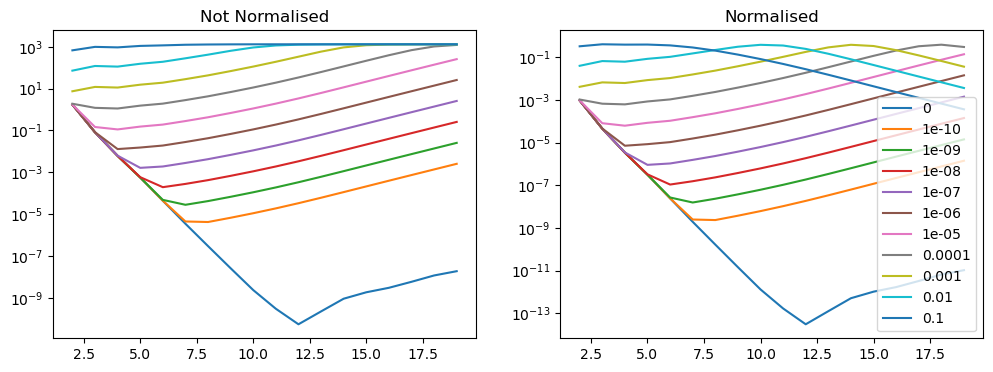

In [33]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Not Normalised")
plt.yscale('log')
plt.subplot(1,2,2)
plt.title("Normalised")
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    m=20
    g_noise_normalised=normalise(g_noise)
    print(f"No normalisation: matrix rank = {matrix_rank(g_noise)}, svd = {svd(g_noise, compute_uv=False)}")
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    print(f"Normalisation: matrix rank = {matrix_rank(g_noise_normalised)}, svd = {svd(g_noise_normalised, compute_uv=False)}")
    distance_svs_noise_normalised = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),norm=True)
    plt.subplot(1,2,1)
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.subplot(1,2,2)
    plt.plot(range(2,m), distance_svs_noise_normalised,label=str(target_noise))
plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

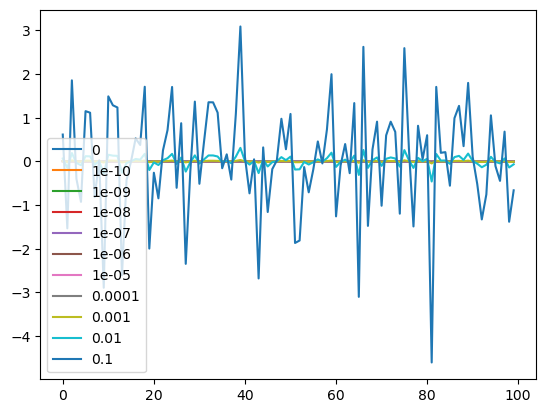

In [14]:
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    plt.plot(u_noise[0],label=str(target_noise))
plt.legend()
#plt.savefig("noise_levels_func.png")
plt.show()


### Try calculationg the derivative with the Fourier Transform

In [6]:
from spectral_derivative import calc_deriv_fftn_with_ext
ux_fft = calc_deriv_fftn_with_ext(u,[x,t],[0],[dx])

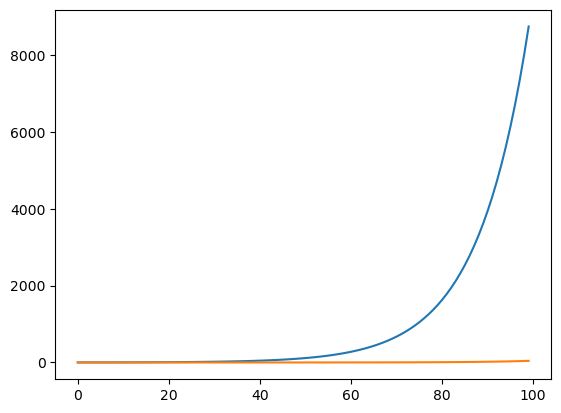

In [7]:
plt.plot(ux_fft[0])
plt.plot(u[0])

In [8]:
from spectral_derivative import calc_deriv_fftn_with_ext
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    #ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    ux_fft = calc_deriv_fftn_with_ext(u_noise,[x,t],[0],[dx])
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_fft.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))


Noise level: 0
2 [7671646.28316754   78682.02570464]
Noise level: 1e-10
2 [7671646.28322649   78682.02575013]
Noise level: 1e-09
2 [7671646.28369561   78682.02548305]
Noise level: 1e-08
2 [7671646.28208482   78682.04085948]
Noise level: 1e-07
2 [7671646.29841853   78681.93871794]
Noise level: 1e-06
2 [7671645.84781758   78682.41149261]
Noise level: 1e-05
2 [7671646.75387154   78670.82751242]
Noise level: 0.0001
2 [7671654.7096643    78870.20482215]
Noise level: 0.001
2 [7672021.25208717  104719.31721605]
Noise level: 0.01
2 [7701105.17618675  697767.39947471]
Noise level: 0.1
2 [11446826.21008806  4606349.88772933]


# Exponential function: $u(t,x)=(bt+x)exp(at)$

In [9]:
experiment_name = "linear_unique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_unique_1
(0.480918327257503*t + x)*exp(-0.0344635869084378*t)


Noise level: 0
2 [0.96091923 0.2768289 ]
Noise level: 1e-10
2 [0.96091923 0.2768289 ]
Noise level: 1e-09
2 [0.96091923 0.2768289 ]
Noise level: 1e-08
2 [0.96091923 0.2768289 ]
Noise level: 1e-07
2 [0.96091926 0.27682879]
Noise level: 1e-06
2 [0.96091943 0.2768282 ]
Noise level: 1e-05
2 [0.96091512 0.27684316]
Noise level: 0.0001
2 [0.96077035 0.27734514]
Noise level: 0.001
2 [0.95323282 0.30223698]
Noise level: 0.01
2 [0.81919899 0.57350939]
Noise level: 0.1
2 [0.9972012  0.07476473]


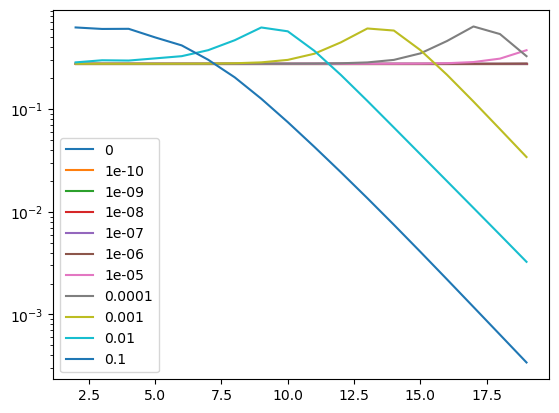

In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    g_noise=normalise(g_noise)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))
    m=20
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

## Examplary Derivative Calculaton: 
Problem: no exact calucaltion despite extension and no noise?

In [11]:
from spectral_derivative import flattenandextendfunc_1d,calc_deriv_fftn

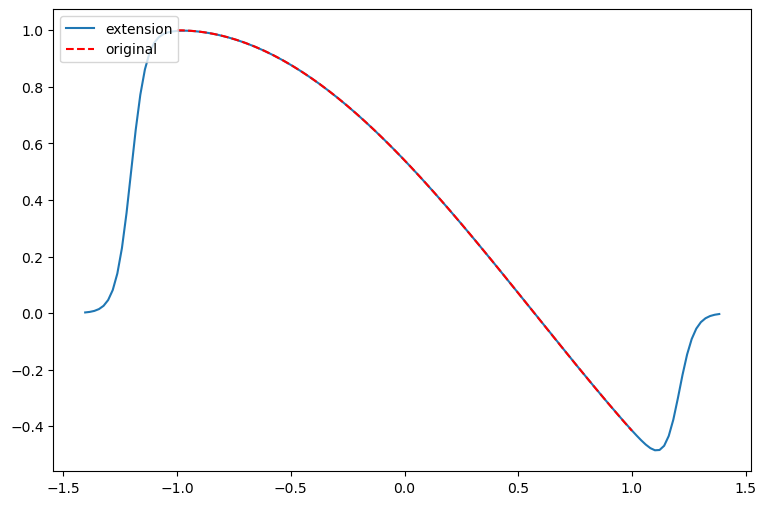

In [12]:
# Do the same for one dimensional function
n= 100# amount of points
L=2#length of domain
dx = L/n
const=0#np.pi/2
a=1
b=1
x = np.linspace(-L/2+const, L/2+const, num=n)
#f = np.exp(a*x+b)
#dfdx = a*np.exp(a*x+b)
f = np.cos(a*x+b)
dfdx = -a*np.sin(a*x+b)
dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f, dx)


newf,newx,newn= flattenandextendfunc_1d(f,x)

plt.figure(figsize=(9,6))
plt.plot(newx,newf, label='extension')
plt.plot(x,f,'--',color='red',label='original')
plt.legend(loc=2)
plt.savefig("Images/Extension.png")
plt.show()


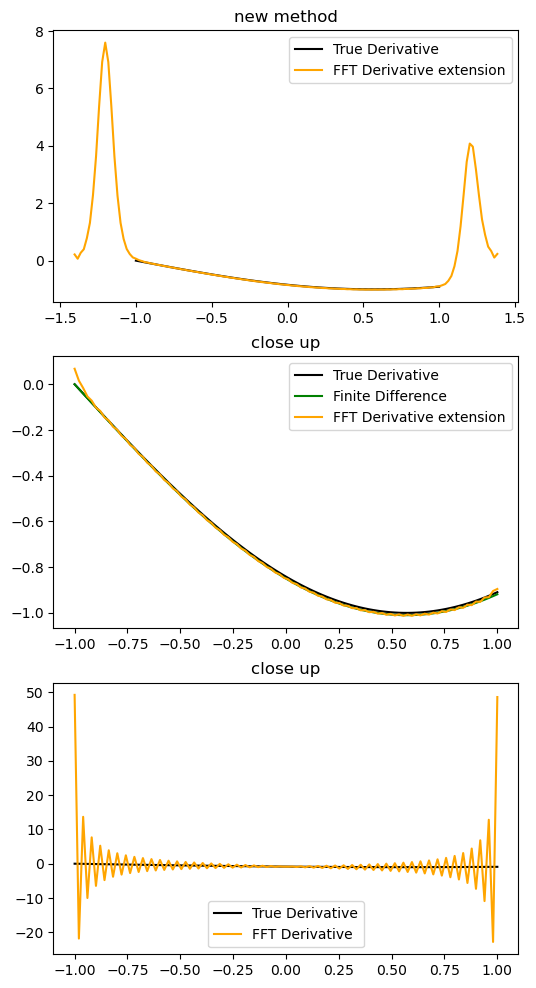

In [13]:
#Check if calculating the derivative holds
dfdx_FFT = calc_deriv_fftn(f,[0], [dx])
newdfdx_FFT = calc_deriv_fftn(newf,[0], [dx])

# Plot Derivatives
plt.figure(figsize=(6,12))
plt.subplot(3,1,1)
plt.title("new method")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(newx,newdfdx_FFT,color='orange', label = 'FFT Derivative extension')
plt.legend(loc=0)

plt.subplot(3,1,2)
plt.title("close up")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(x,dfdx_fd, color='green', label ='Finite Difference')
plt.plot(x,newdfdx_FFT[newn:newn+f.size],color='orange', label = 'FFT Derivative extension')
plt.legend(loc=0)

plt.subplot(3,1,3)
plt.title("close up")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(x,dfdx_FFT,color='orange', label = 'FFT Derivative')
plt.legend(loc=0)
plt.savefig("Images/derivative_calc.png")

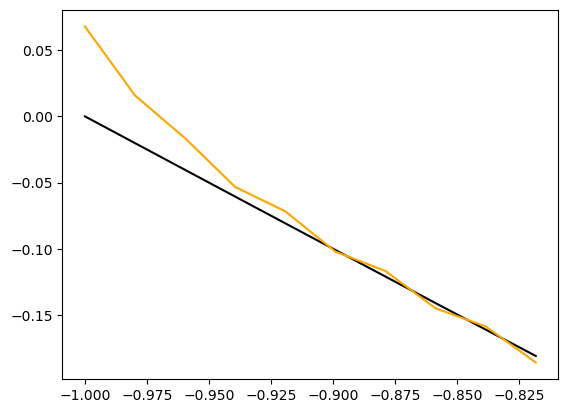

In [14]:
n=10
#Why do I get this artefacts?? 
plt.plot(x[:n],dfdx[:n], color='k', label ='True Derivative')
plt.plot(x[:n],newdfdx_FFT[newn:newn+f.size][:n],color='orange', label = 'FFT Derivative extension')
plt.savefig("Images/derivative_calc_closeup.png")